# Stochastic Models and Simulations of Phototaxis
[Link](https://www.researchgate.net/profile/Devaki-Bhaya/publication/265289716_Stochastic_Models_and_Simulations_of_Phototaxis/links/5535445a0cf268fd0015d694/Stochastic-Models-and-Simulations-of-Phototaxis.pdf)

In [1]:
using Random, LinearAlgebra, Plots, Statistics

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


# Functions

In [ ]:
"""
Convert polar coordinates to cartesian
"""
polar2cart(r, θ) = r .* [cos(θ) sin(θ)]

"""
Sample N points from a circle of radius R
https://stackoverflow.com/questions/5837572/generate-a-random-point-within-a-circle-uniformly/50746409

"""
function sampleCircle(N, R)
    # Sample radii
    # PDF = 2x; CDF = x²; CDF⁻¹ = √x
    radii = R * sqrt.(rand(N))
    
    # Sample angles
    # theta = 0 - 2π
    thetas = rand(N) * 2π

    # points
    X = polar2cart.(radii, thetas)
    return X
end


"""Compute all pairwise distances between each point in X
Store in condensed distance matrix form (flattening of upper triangle)

# Inputs
| X: n (observations) x m (dimensions) matrix 
| f(a, b): function to compute distances between a, b
"""
function pairwiseDistance(X, f)
    n = size(X)[1]
    dists = zeros(n, n)
    for i in 1:n
        a = X[i]
        for j in i:n
            b = X[j]
            # Compute distance
            d = f(a, b)
            # Save
            dists[i, j] = dists[j, i] = d
        end
    end
    return dists
end

"""
Compute Euclidean distance between a and b
"""
euclidDist(a, b) = norm(a - b)

"""
Sample n points from a PDF, p
"""
function sampleDiscrete(n, p)
    # Compute cdf (Normalize to sum to 1)
    cdf = cumsum(p) / sum(p)
    # Sample
    choices = [searchsortedfirst(cdf, rand()) for _ in 1:n]
end

"""
Initialize model with N points in a radius R
"""
function initialize(N, R)
    # Initialize points
    X = sampleCircle(N, R)

    # Initialize directions
    θ = rand(N) * 2pi
    # Convert to polar
    θ = polar2cart.(1, θ)

    # Initialize velocities
    v = rand(N) .> .5
    
    return X, v, θ
end

"""
Perform one step of the provided model
"""
function stepModel(θ, v, X, p)
    # Select new v and θ
    v, θ = phototaxis(θ, v, X, p)

    # Update
    old_X = X
    X += v .* θ

    # Enforce boundary conditions
    outside = norm.(X) .> R
    X[outside] = old_X[outside]
    return X, v, θ
end

"""
Update step for phototaxis model

Local interactions: p["leader"] = zeros(N)
Global forcing model: p["leader"] != zeros(N)

# Inputs
| θ: Vector of directions (polar coordinates) for each point
| v: Vector of velocities for each point (0 or 1)
| X: Array{Array{Float64, 2}, 1} of points
| p: Dictionary of parameters 
    a: P[not changing direction]
    b: P[not changing velocity]
    c: P[moving toward light]
    D: Radius of interaction
    leader: vector of leader labels (0 or 1)
"""
function phototaxis(θ, v, X, p)
    N = size(X)[1]
    """Compute pairwise distances"""
    dists = pairwiseDistance(X, euclidDist)
    
    
    """Get new direction"""
    # Find local interactions for each point
    B = dists .< p["D"]
    # Number of neighbhors
    nB = sum(B, dims=2) .- 1
    # Probability of changing towards neighbor for leaders
    p_leader = replace((1 - p["a"])./nB, Inf=>0)
    # Probability of changing towards neighbors for normals
    p_normal = replace((1 - p["a"])./nB, Inf=>0)
    # Probability of orienting towards neighbor for each cell
    p_neighbor = @.p["leader"] * p_leader + (1 - p["leader"]) * p_normal

    #  P[swithing to j] = (1-c-a)/nB
    PDFs = B .* p_neighbor
    
    # Add P[toward light] = c.
    PDFs[:, end] .= p["c"]
    
    # [same direction] = a;
    PDFs[diagind(PDFs)] = 1 - p["c"] .- p_neighbor
    
    # Set light source to stay in place
    PDFs[end, :] .= 0
    PDFs[end, end] = 1

    # Sample new direction for each point
    new_X_idx = [sampleDiscrete(1, pdf)[1] for pdf = eachrow(PDFs)]
    
    # Get coresponding point
    new_X = X[new_X_idx]
    # Get new direction (X + new_dir = new_X => new_dir = new_X - X)
    new_dir = new_X - X
    new_dir_mag = norm.(new_X - X)
    
    # For points without neighbors, θ stays same, otherwise update direction
    new_θ = [new_dir_mag[i] == 0 ? θ[i] : new_dir[i]/new_dir_mag[i] for i=1:N]

    """Get new velocity"""
    change_v = rand(N) .< p["b"]
    new_v = [change_v[i] ? v[i] : Bool(1-v[i]) for i in 1:N]
    
    return new_v, new_θ
end

In [45]:
"""Parameters"""
p = Dict{Any, Any}("a"=>.8, "b"=>.5, "c"=>.005)

p

# Local interactions
At any
given point in time, we assume that every cell may move according to one of the
following three options (shown in Figure 2):
1. a cell may continue to move without changing its previous direction
2.  a cell can stop moving
3. a cell may orient itself. In this case it will moves in the direction of one of its
neighboring cells. The candidate neighboring cells must be within a certain
interaction distance (shown as the dotted circle in Figure 2(c)).

In [44]:
"""
Update step for local interactions model

# Inputs
| θ: Vector of directions (polar coordinates) for each point
| v: Vector of velocities for each point (0 or 1)
| X: Array{Array{Float64, 2}, 1} of points
| p: Dictionary of parameters 
    a: P[not changing direction]
    b: P[not changing velocity]
    D: Radius of interaction
"""
function localInteractionsUpdate(θ, v, X, p)
    N = size(X)[1]
    """Compute pairwise distances"""
    dists = pairwiseDistance(X, euclidDist)
    
    """Get new direction"""
    # Find local interactions for each point
    B = dists .< p["D"]
    # Number of neighbhors
    nB = sum(B, dims=2) .- 1
    
    # P[swithing to j] = (1-a)/nB
    p_transition = replace((1-p["a"])./nB, Inf=>0)
    PDFs = B .* p_transition
    
    # P[same direction] = a; 
    PDFs[diagind(PDFs)] = 1 .- p_transition

    # Sample new direction for each point
    new_X_idx = [sampleDiscrete(1, pdf)[1] for pdf = eachrow(PDFs)]
    
    # Get coresponding point
    new_X = X[new_X_idx]
    # Get new direction (X + new_dir = new_X => new_dir = new_X - X)
    new_dir = new_X - X
    new_dir_mag = norm.(new_X - X)
    
    # For points without neighbors, θ stays same, otherwise update direction
    new_θ = [new_dir_mag[i] == 0 ? θ[i] : new_dir[i]/new_dir_mag[i] for i=1:N]

    """Get new velocity"""
    change_v = rand(N) .< p["b"]
    new_v = [change_v[i] ? v[i] : Bool(1-v[i]) for i in 1:N]
    
    return new_v, new_θ
end

localInteractionsUpdate

In [46]:
@time begin
    # Save nested dictionaries by D then N
    data = Dict()
    R = 250
    
    # Times to run to and save
    tf = 350
    save_ts = [50, 350]
    
    # Parameters to loop over
    Ds = [5, 10]
    Ns = [250, 500]
    for D = Ds
        D_data = Dict()
        for N = Ns
            # Initialize
            X, v, θ = initialize(N, R)
            p["D"] = D

            # Local interactions model = no leaders
            p["leader"] = zeros()
            
            # Run simulation
            Xs = [X]
            t = 1
            
            while t < (tf + 1)
                # Run one step of model
                X, v, θ = stepModel(θ, v, X, p)

                # Save X at times of interes
                if t in save_ts
                    push!(Xs, X)
                end
                if t == tf
                    break
                end

                # Recompute pairwise distances
                dists = pairwiseDistance(X, euclidDist)
                t += 1
            end
            # Save simulations for this N
            D_data[N] = Xs
        end
        # Save simulations for this D
        data[D] = D_data
    end
end

 19.152934 seconds (224.42 M allocations: 28.310 GiB, 16.59% gc time)


## Visualize

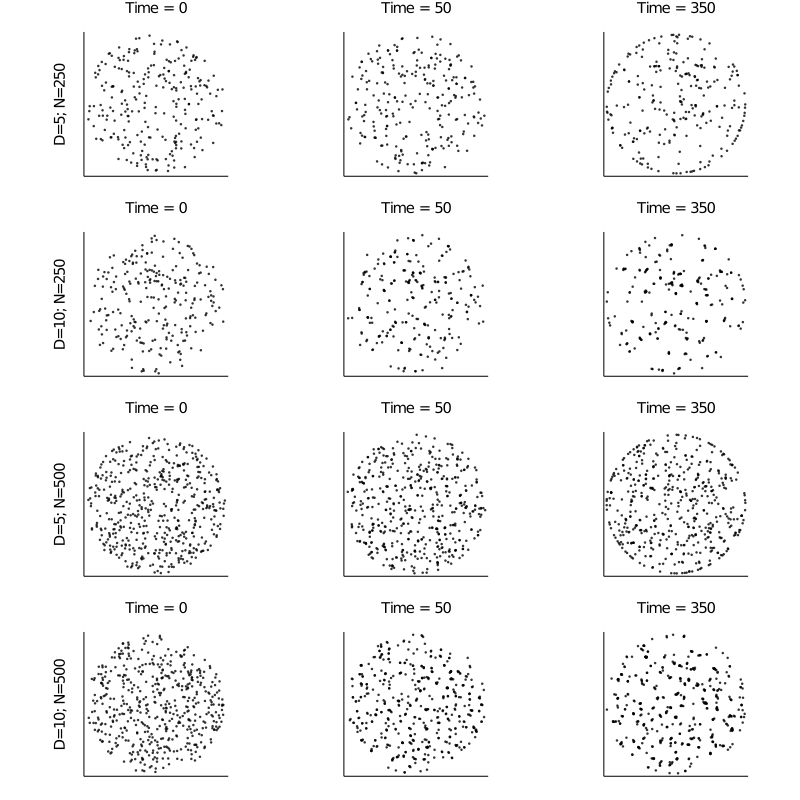

In [10]:
plts = []
for N = Ns
    for D = Ds
        d = data[D][N]
        for (x, t) in zip(d, [0, 50, 350])
            # Convert data to matrix
            Xmat = vcat(x...)
            # Scatter points
            plt = scatter(Xmat[:, 1], Xmat[:, 2], aspect_ratio=:equal, legend=false, markersize=1.5, alpha=.8, color=:black)
            title!("Time = $t")
            # Add details to left y-axis
            if t == 0
                ylabel!("D=$D; N=$N")
            end
            push!(plts, plt)
        end
    end
end
# Show
lims = (-R-10, R+10)
plt = plot(plts..., titlefontsize=10, yguidefontsize=10, layout=(4, 3), size=(800, 800), xlim=lims, ylims=lims, axis=nothing)
savefig(plt, "results/fig4")
plt

# Global Forcing Model - A
Local interaction model with influence of a global attractor that all cells are sensitive to.

In [11]:
"""
Update step for local interactions model

# Inputs
| θ: Vector of directions (polar coordinates) for each point
| v: Vector of velocities for each point (0 or 1)
| X: Array{Array{Float64, 2}, 1} of points
| p: Dictionary of parameters 
    a: P[not changing direction]
    b: P[not changing velocity]
    c: P[moving toward light]
    D: Radius of interaction
"""
function globalForcingUpdate(θ, v, X, p)
    N = size(X)[1]
    """Compute pairwise distances"""
    dists = pairwiseDistance(X, euclidDist)
    
    
    """Get new direction"""
    # Find local interactions for each point
    B = dists .< p["D"]
    # Number of neighbhors
    nB = sum(B, dims=2) .- 1
    # Probability of changing is uniform across neighbors
    p_transition = replace((1-p["c"] - p["a"])./nB, Inf=>0)

    #  P[swithing to j] = (1-c-a)/nB
    PDFs = B .* p_transition
    
    # Add P[toward light] = c.
    PDFs[:, end] .= p["c"]
    
    # [same direction] = a;
    PDFs[diagind(PDFs)] = 1 - p["c"] .- p_transition
    
    # Set light source to stay in place
    PDFs[end, :] .= 0
    PDFs[end, end] = 1

    # Sample new direction for each point
    new_X_idx = [sampleDiscrete(1, pdf)[1] for pdf = eachrow(PDFs)]
    
    # Get coresponding point
    new_X = X[new_X_idx]
    # Get new direction (X + new_dir = new_X => new_dir = new_X - X)
    new_dir = new_X - X
    new_dir_mag = norm.(new_X - X)
    
    # For points without neighbors, θ stays same, otherwise update direction
    new_θ = [new_dir_mag[i] == 0 ? θ[i] : new_dir[i]/new_dir_mag[i] for i=1:N]

    """Get new velocity"""
    change_v = rand(N) .< p["b"]
    new_v = [change_v[i] ? v[i] : Bool(1-v[i]) for i in 1:N]
    
    return new_v, new_θ
end

globalForcingUpdate

In [ ]:
@time begin
    # Save nested dictionaries by D then N
    data = Dict()
    R = 250
    # Location of light source
    θ₀ = polar2cart(R, -pi/4)
    
    # Times to run to and save
    tf = 1000
    save_ts = [500, 1000]
    
    # Parameters to loop over
    Ds = [5, 10]
    Ns = [250, 500]
    for D = Ds
        D_data = Dict()
        for N = Ns
            # Initialize
            X, v, θ = initialize(N, R)
            # Add light source as final point
            push!(X, θ₀)
            push!(θ, [0 0])
            push!(v, 0)
            
            # Global forcing model A - all leaders
            p["leader"] = ones(N+1)
            p["D"] = D
            
            # Run simulation
            Xs = [X]
            t = 1
            
            while t < (tf + 1)
                # Run one step of model
                X, v, θ = stepModel(θ, v, X, p)

                # Save X at times of interes
                if t in save_ts
                    push!(Xs, X)
                end
                if t == tf
                    break
                end

                # Recompute pairwise distances
                dists = pairwiseDistance(X, euclidDist)
                t += 1
            end
            # Save simulations for this N
            D_data[N] = Xs
        end
        # Save simulations for this D
        data[D] = D_data
    end
end

In [ ]:
plts = []
for N = Ns
    for D = Ds
        d = data[D][N]
        for (x, t) in zip(d, [0, 50, 350])
            # Convert data to matrix
            Xmat = vcat(x...)
            # Scatter points
            plt = scatter(Xmat[:, 1], Xmat[:, 2], aspect_ratio=:equal, legend=false, markersize=1.5, alpha=.8, color=:black)
            # Add light
            scatter!([θ₀[1]],[θ₀[2]], color=:yellow)
            title!("Time = $t")
            # Add details to left y-axis
            if t == 0
                ylabel!("D=$D; N=$N")
            end
            push!(plts, plt)
        end
    end
end
# Show
lims = (-R-10, R+10)
plt = plot(plts..., titlefontsize=10, yguidefontsize=10, layout=(4, 3), size=(800, 800), xlim=lims, ylims=lims, axis=nothing)
savefig(plt, "results/fig5")
plt

# Global forcing - B
In this model, only a subset of cells are capable of sensing the direc- tion of the light source. To model this, cells are randomly assigned to be of type leader or type normal. Cells of the leader subtype update directions according to equation (4). Cells of the normal subtype update directions according to equation (1). The ratio of leader to normal cells is a model parameter. Its effect is studied in the numerical simulations.

In [43]:
"""
Update step for phototaxis model

Local interactions: p["leader"] = zeros(N)
Global forcing model: p["leader"] != zeros(N)

# Inputs
| θ: Vector of directions (polar coordinates) for each point
| v: Vector of velocities for each point (0 or 1)
| X: Array{Array{Float64, 2}, 1} of points
| p: Dictionary of parameters 
    a: P[not changing direction]
    b: P[not changing velocity]
    c: P[moving toward light]
    D: Radius of interaction
    leader: vector of leader labels (0 or 1)
"""
function phototaxis(θ, v, X, p)
    N = size(X)[1]
    """Compute pairwise distances"""
    dists = pairwiseDistance(X, euclidDist)
    
    
    """Get new direction"""
    # Find local interactions for each point
    B = dists .< p["D"]
    # Number of neighbhors
    nB = sum(B, dims=2) .- 1
    # Probability of changing towards neighbor for leaders
    p_leader = replace((1 - p["a"])./nB, Inf=>0)
    # Probability of changing towards neighbors for normals
    p_normal = replace((1 - p["a"])./nB, Inf=>0)
    # Probability of orienting towards neighbor for each cell
    p_neighbor = @.p["leader"] * p_leader + (1 - p["leader"]) * p_normal

    #  P[swithing to j] = (1-c-a)/nB
    PDFs = B .* p_neighbor
    
    # Add P[toward light] = c.
    PDFs[:, end] .= p["c"]
    
    # [same direction] = a;
    PDFs[diagind(PDFs)] = 1 - p["c"] .- p_neighbor
    
    # Set light source to stay in place
    PDFs[end, :] .= 0
    PDFs[end, end] = 1

    # Sample new direction for each point
    new_X_idx = [sampleDiscrete(1, pdf)[1] for pdf = eachrow(PDFs)]
    
    # Get coresponding point
    new_X = X[new_X_idx]
    # Get new direction (X + new_dir = new_X => new_dir = new_X - X)
    new_dir = new_X - X
    new_dir_mag = norm.(new_X - X)
    
    # For points without neighbors, θ stays same, otherwise update direction
    new_θ = [new_dir_mag[i] == 0 ? θ[i] : new_dir[i]/new_dir_mag[i] for i=1:N]

    """Get new velocity"""
    change_v = rand(N) .< p["b"]
    new_v = [change_v[i] ? v[i] : Bool(1-v[i]) for i in 1:N]
    
    return new_v, new_θ
end

phototaxis

In [41]:
N = 250
R = 200

X, v, θ = initialize(N, R)

# Leader labeling
p["leader"] = rand(N) .> .5 

"""Compute pairwise distances"""
dists = pairwiseDistance(X, euclidDist)


"""Get new direction"""
# Find local interactions for each point
B = dists .< p["D"]
# Number of neighbhors
nB = sum(B, dims=2) .- 1
# Probability of changing towards neighbor for leaders
p_leader = replace((1 - p["a"])./nB, Inf=>0)
# Probability of changing towards neighbors for normals
p_normal = replace((1 - p["a"])./nB, Inf=>0)
# Probability of orienting towards neighbor for each cell
p_neighbor = @.p["leader"] * p_leader + (1 - p["leader"]) * p_normal

250×1 Array{Float64,2}:
 0.19999999999999996
 0.0
 0.19999999999999996
 0.0
 0.0
 0.19999999999999996
 0.19999999999999996
 0.0
 0.19999999999999996
 0.0
 0.19999999999999996
 0.19999999999999996
 0.19999999999999996
 ⋮
 0.09999999999999998
 0.0
 0.0
 0.19999999999999996
 0.19999999999999996
 0.0
 0.0
 0.0
 0.09999999999999998
 0.19999999999999996
 0.09999999999999998
 0.19999999999999996

250×1 Array{Float64,2}:
 0.19999999999999996
 0.0
 0.19999999999999996
 0.19999999999999996
 0.19999999999999996
 0.19999999999999996
 0.19999999999999996
 0.0
 0.09999999999999998
 0.04999999999999999
 0.0
 0.0
 0.19999999999999996
 ⋮
 0.19999999999999996
 0.0
 0.19999999999999996
 0.0
 0.0
 0.0
 0.19999999999999996
 0.19999999999999996
 0.19999999999999996
 0.0
 0.0
 0.19999999999999996